In [3]:
#Essential Imports
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
#Reading data directly and splitting it
file_path = 'diabetes_scale.txt' 
with open(file_path, 'r') as file:
    data = []
    for line in file:
        data.append(line.strip().split())

num_features = 8

labels = []
features = []

for row in data:
    labels.append(int(row[0]))
    
    feature_row = []
    
    for item in row[1:num_features + 1]:
        feature_row.append(float(item.split(":")[1]))
    
    features.append(feature_row)

df = pd.DataFrame(features, columns=[f'feature_{i+1}' for i in range(num_features)])
df['label'] = labels

# Move 'label' column to the front
df = df[['label'] + [col for col in df.columns if col != 'label']]

df.head()

,label,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8
0,-1,-0.294118,0.487437,0.180328,-0.292929,-1.000000,0.001490,-0.531170,-0.033333
1,1,-0.882353,-0.145729,0.081967,-0.414141,-1.000000,-0.207153,-0.766866,-0.666667
2,-1,-0.058824,0.839196,0.049180,-1.000000,-1.000000,-0.305514,-0.492741,-0.633333
3,1,-0.882353,-0.105528,0.081967,-0.535354,-0.777778,-0.162444,-0.923997,-1.000000
4,-1,-1.000000,0.376884,-0.344262,-0.292929,-0.602837,0.284650,0.887276,-0.600000


In [5]:
#Custom Perceptron Model
class CustomPerceptron:
    def __init__(self, learning_rate=0.01, max_iter=1000):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.max_iter):
            for idx, x_i in enumerate(X):
                linear_output = np.dot(x_i, self.weights) + self.bias
                y_predicted = np.where(linear_output >= 0, 1, -1)
                
                if y_predicted != y[idx]:
                    update = self.learning_rate * y[idx]
                    self.weights += update * x_i
                    self.bias += update

    def predict(self, X):
        linear_output = np.dot(X, self.weights) + self.bias
        return np.where(linear_output >= 0, 1, -1)


# Cross-validation and performance metrics function
def evaluate_perceptron_with_cross_validation(X, y, learning_rate=0.01, max_iter=1000, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': [],
        'confusion_matrices': []
    }

    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        #training model
        model = CustomPerceptron(learning_rate=learning_rate, max_iter=max_iter)
        model.fit(X_train, y_train)

        #Predict on test set
        y_pred = model.predict(X_test)

        fold_metrics['accuracy'].append(accuracy_score(y_test, y_pred))
        fold_metrics['precision'].append(precision_score(y_test, y_pred, zero_division=1))
        fold_metrics['recall'].append(recall_score(y_test, y_pred, zero_division=1))
        fold_metrics['f1_score'].append(f1_score(y_test, y_pred, zero_division=1))
        fold_metrics['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

        print(f"Fold {fold + 1} - Accuracy: {fold_metrics['accuracy'][-1]:.4f}, "
              f"Precision: {fold_metrics['precision'][-1]:.4f}, "
              f"Recall: {fold_metrics['recall'][-1]:.4f}, "
              f"F1-Score: {fold_metrics['f1_score'][-1]:.4f}")

    plt.figure(figsize=(6, 4))
    sns.heatmap(fold_metrics['confusion_matrices'][-1], annot=True, fmt='d', cmap='Blues', cbar=True)
    plt.title(f'Confusion Matrix (Learning Rate: {learning_rate}, Max Iter: {max_iter})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return fold_metrics 

Fold 1 - Accuracy: 0.7143, Precision: 0.8667, Recall: 0.6566, F1-Score: 0.7471
Fold 2 - Accuracy: 0.6948, Precision: 0.8333, Recall: 0.7009, F1-Score: 0.7614
Fold 3 - Accuracy: 0.5130, Precision: 0.8750, Recall: 0.2258, F1-Score: 0.3590
Fold 4 - Accuracy: 0.6601, Precision: 0.9219, Recall: 0.5566, F1-Score: 0.6941
Fold 5 - Accuracy: 0.6797, Precision: 0.7500, Recall: 0.7263, F1-Score: 0.7380


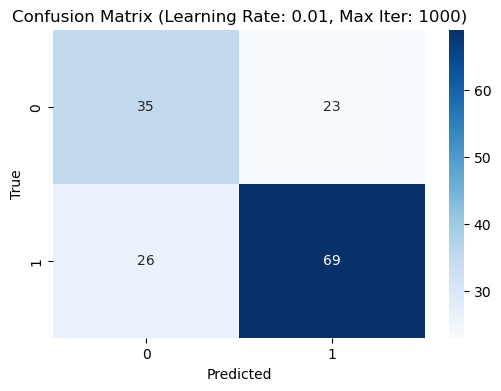

Overall Performance Across Folds:
Average Accuracy: 0.6523894406247347
Average Precision: 0.849375
Average Recall: 0.5732452501352804
Average F1-Score: 0.6599215354100497


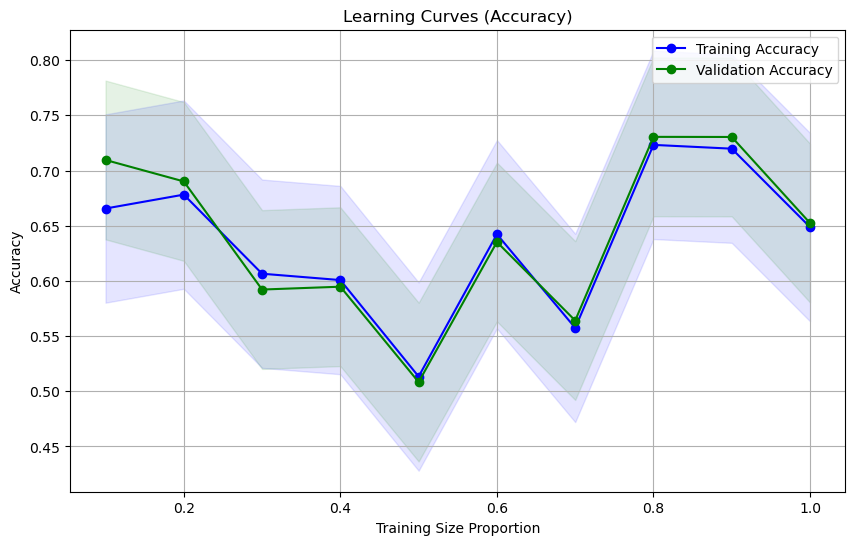

In [22]:
# Learning curve plotting function
def plot_learning_curves(X, y, learning_rate=0.01, max_iter=1000, n_splits=5):
    train_sizes = np.linspace(0.1, 1.0, 10)
    train_accuracies, test_accuracies = [], []

    for train_size in train_sizes:
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        fold_train_accuracies = []
        fold_test_accuracies = []

        for train_idx, test_idx in kf.split(X):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            X_train_frac = X_train[:int(len(X_train) * train_size)]
            y_train_frac = y_train[:int(len(y_train) * train_size)]

            #Training model
            model = CustomPerceptron(learning_rate=learning_rate, max_iter=max_iter)
            model.fit(X_train_frac, y_train_frac)

            #Evaluate on both training and test sets
            train_accuracy = accuracy_score(y_train_frac, model.predict(X_train_frac))
            test_accuracy = accuracy_score(y_test, model.predict(X_test))

            fold_train_accuracies.append(train_accuracy)
            fold_test_accuracies.append(test_accuracy)

        train_accuracies.append(np.mean(fold_train_accuracies))
        test_accuracies.append(np.mean(fold_test_accuracies))

    #Plot the learning curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_accuracies, label="Training Accuracy", marker='o', color='blue')
    plt.plot(train_sizes, test_accuracies, label="Validation Accuracy", marker='o', color='green')

    #Add shading for the standard deviation
    plt.fill_between(train_sizes, np.array(train_accuracies) - np.std(fold_train_accuracies),
                     np.array(train_accuracies) + np.std(fold_train_accuracies), color='blue', alpha=0.1)
    plt.fill_between(train_sizes, np.array(test_accuracies) - np.std(fold_test_accuracies),
                     np.array(test_accuracies) + np.std(fold_test_accuracies), color='green', alpha=0.1)

    plt.title("Learning Curves (Accuracy)")
    plt.xlabel("Training Size Proportion")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()


#Converting to numpy arrays
X = df.drop('label', axis=1).to_numpy()  # Ensure X is a numpy array
y = df['label'].to_numpy()  # Ensure y is a numpy array

#Evaluate Perceptron using cross-validation
metrics = evaluate_perceptron_with_cross_validation(X, y, learning_rate=0.01, max_iter=1000, n_splits=5)

print("Overall Performance Across Folds:")
print("Average Accuracy:", np.mean(metrics['accuracy']))
print("Average Precision:", np.mean(metrics['precision']))
print("Average Recall:", np.mean(metrics['recall']))
print("Average F1-Score:", np.mean(metrics['f1_score']))

#Plot the learning curves
plot_learning_curves(X, y, learning_rate=0.01, max_iter=1000, n_splits=5)
